In [126]:
# %matplotlib widget

from __future__ import annotations

import re
from collections import defaultdict
from dataclasses import dataclass, field
from itertools import permutations, product
from math import inf
from random import choice

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.typing as npt
from mpl_toolkits.mplot3d import axes3d
from numpy import int_, object_
from numpy.typing import NDArray
from test_utilities import test
from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())

<link href="style.css" rel="stylesheet"></link>
<article class="day-desc"><h2>--- Day 10: Cathode-Ray Tube ---</h2><p>You avoid the ropes, plunge into the river, and swim to shore.</p>
<p>The Elves yell something about meeting back up with them upriver, but the river is too loud to tell exactly what they're saying. They finish crossing the bridge and disappear from view.</p>
<p>Situations like this must be why the Elves prioritized getting the communication system on your handheld device working. You pull it out of your pack, but the amount of water slowly draining from a big crack in its screen tells you it probably won't be of much immediate use.</p>
<p><em>Unless</em>, that is, you can design a replacement for the device's video system! It seems to be some kind of <a href="https://en.wikipedia.org/wiki/Cathode-ray_tube" target="_blank">cathode-ray tube</a> screen and simple CPU that are both driven by a precise <em>clock circuit</em>. The clock circuit ticks at a constant rate; each tick is called a <em>cycle</em>.</p>
<p>Start by figuring out the signal being sent by the CPU. The CPU has a single register, <code>X</code>, which starts with the value <code>1</code>. It supports only two instructions:</p>
<ul>
<li><code>addx V</code> takes <em>two cycles</em> to complete. <em>After</em> two cycles, the <code>X</code> register is increased by the value <code>V</code>. (<code>V</code> can be negative.)</li>
<li><code>noop</code> takes <em>one cycle</em> to complete. It has no other effect.</li>
</ul>
<p>The CPU uses these instructions in a program (your puzzle input) to, somehow, tell the screen what to draw.</p>
<p>Consider the following small program:</p>
<pre><code>noop
addx 3
addx -5
</code></pre>
<p>Execution of this program proceeds as follows:</p>
<ul>
<li>At the start of the first cycle, the <code>noop</code> instruction begins execution. During the first cycle, <code>X</code> is <code>1</code>. After the first cycle, the <code>noop</code> instruction finishes execution, doing nothing.</li>
<li>At the start of the second cycle, the <code>addx 3</code> instruction begins execution. During the second cycle, <code>X</code> is still <code>1</code>.</li>
<li>During the third cycle, <code>X</code> is still <code>1</code>. After the third cycle, the <code>addx 3</code> instruction finishes execution, setting <code>X</code> to <code>4</code>.</li>
<li>At the start of the fourth cycle, the <code>addx -5</code> instruction begins execution. During the fourth cycle, <code>X</code> is still <code>4</code>.</li>
<li>During the fifth cycle, <code>X</code> is still <code>4</code>. After the fifth cycle, the <code>addx -5</code> instruction finishes execution, setting <code>X</code> to <code>-1</code>.</li>
</ul>
<p>Maybe you can learn something by looking at the value of the <code>X</code> register throughout execution. For now, consider the <em>signal strength</em> (the cycle number multiplied by the value of the <code>X</code> register) <em>during</em> the 20th cycle and every 40 cycles after that (that is, during the 20th, 60th, 100th, 140th, 180th, and 220th cycles).</p>
<p>For example, consider this larger program:</p>
<pre><code>addx 15
addx -11
addx 6
addx -3
addx 5
addx -1
addx -8
addx 13
addx 4
noop
addx -1
addx 5
addx -1
addx 5
addx -1
addx 5
addx -1
addx 5
addx -1
addx -35
addx 1
addx 24
addx -19
addx 1
addx 16
addx -11
noop
noop
addx 21
addx -15
noop
noop
addx -3
addx 9
addx 1
addx -3
addx 8
addx 1
addx 5
noop
noop
noop
noop
noop
addx -36
noop
addx 1
addx 7
noop
noop
noop
addx 2
addx 6
noop
noop
noop
noop
noop
addx 1
noop
noop
addx 7
addx 1
noop
addx -13
addx 13
addx 7
noop
addx 1
addx -33
noop
noop
noop
addx 2
noop
noop
noop
addx 8
noop
addx -1
addx 2
addx 1
noop
addx 17
addx -9
addx 1
addx 1
addx -3
addx 11
noop
noop
addx 1
noop
addx 1
noop
noop
addx -13
addx -19
addx 1
addx 3
addx 26
addx -30
addx 12
addx -1
addx 3
addx 1
noop
noop
noop
addx -9
addx 18
addx 1
addx 2
noop
noop
addx 9
noop
noop
noop
addx -1
addx 2
addx -37
addx 1
addx 3
noop
addx 15
addx -21
addx 22
addx -6
addx 1
noop
addx 2
addx 1
noop
addx -10
noop
noop
addx 20
addx 1
addx 2
addx 2
addx -6
addx -11
noop
noop
noop
</code></pre>
<p>The interesting signal strengths can be determined as follows:</p>
<ul>
<li>During the 20th cycle, register <code>X</code> has the value <code>21</code>, so the signal strength is 20 * 21 = <em>420</em>. (The 20th cycle occurs in the middle of the second <code>addx -1</code>, so the value of register <code>X</code> is the starting value, <code>1</code>, plus all of the other <code>addx</code> values up to that point: 1 + 15 - 11 + 6 - 3 + 5 - 1 - 8 + 13 + 4 = 21.)</li>
<li>During the 60th cycle, register <code>X</code> has the value <code>19</code>, so the signal strength is 60 * 19 = <code><em>1140</em></code>.</li>
<li>During the 100th cycle, register <code>X</code> has the value <code>18</code>, so the signal strength is 100 * 18 = <code><em>1800</em></code>.</li>
<li>During the 140th cycle, register <code>X</code> has the value <code>21</code>, so the signal strength is 140 * 21 = <code><em>2940</em></code>.</li>
<li>During the 180th cycle, register <code>X</code> has the value <code>16</code>, so the signal strength is 180 * 16 = <code><em>2880</em></code>.</li>
<li>During the 220th cycle, register <code>X</code> has the value <code>18</code>, so the signal strength is 220 * 18 = <code><em>3960</em></code>.</li>
</ul>
<p>The sum of these signal strengths is <code><em>13140</em></code>.</p>
<p>Find the signal strength during the 20th, 60th, 100th, 140th, 180th, and 220th cycles. <em>What is the sum of these six signal strengths?</em></p>
</article>


In [127]:
def sum_signal_strengths(s: str) -> int:
    x = 1
    cycle = 1
    ceck_cycles = list(reversed([20, 60, 100, 140, 180, 220]))
    signal_strength = 0

    instructions = [l.strip().split() for l in s.strip().splitlines()]

    for inst in instructions:
        if inst[0] == "addx":
            cycle += 2
            if ceck_cycles and cycle > ceck_cycles[-1]:
                signal_strength += x * ceck_cycles.pop()
            x += int(inst[1])
        else:
            cycle += 1
            if ceck_cycles and cycle > ceck_cycles[-1]:
                signal_strength += x * ceck_cycles.pop()

    return signal_strength

In [128]:
tests = [
    {
        "name": "Example",
        "s": """
            addx 15
            addx -11
            addx 6
            addx -3
            addx 5
            addx -1
            addx -8
            addx 13
            addx 4
            noop
            addx -1
            addx 5
            addx -1
            addx 5
            addx -1
            addx 5
            addx -1
            addx 5
            addx -1
            addx -35
            addx 1
            addx 24
            addx -19
            addx 1
            addx 16
            addx -11
            noop
            noop
            addx 21
            addx -15
            noop
            noop
            addx -3
            addx 9
            addx 1
            addx -3
            addx 8
            addx 1
            addx 5
            noop
            noop
            noop
            noop
            noop
            addx -36
            noop
            addx 1
            addx 7
            noop
            noop
            noop
            addx 2
            addx 6
            noop
            noop
            noop
            noop
            noop
            addx 1
            noop
            noop
            addx 7
            addx 1
            noop
            addx -13
            addx 13
            addx 7
            noop
            addx 1
            addx -33
            noop
            noop
            noop
            addx 2
            noop
            noop
            noop
            addx 8
            noop
            addx -1
            addx 2
            addx 1
            noop
            addx 17
            addx -9
            addx 1
            addx 1
            addx -3
            addx 11
            noop
            noop
            addx 1
            noop
            addx 1
            noop
            noop
            addx -13
            addx -19
            addx 1
            addx 3
            addx 26
            addx -30
            addx 12
            addx -1
            addx 3
            addx 1
            noop
            noop
            noop
            addx -9
            addx 18
            addx 1
            addx 2
            noop
            noop
            addx 9
            noop
            noop
            noop
            addx -1
            addx 2
            addx -37
            addx 1
            addx 3
            noop
            addx 15
            addx -21
            addx 22
            addx -6
            addx 1
            noop
            addx 2
            addx 1
            noop
            addx -10
            noop
            noop
            addx 20
            addx 1
            addx 2
            addx 2
            addx -6
            addx -11
            noop
            noop
            noop
        """,
        "expected": 13140,
    },
]


@test(tests=tests)
def test_part_I(s: str) -> int:
    return sum_signal_strengths(s)


Test Example passed, for test_part_I.
Success


In [129]:
with open("../input/day10.txt") as f:
    puzzle = f.read()

print(f"Part 1: {sum_signal_strengths(puzzle)}")

Part 1: 13680


<link href="style.css" rel="stylesheet"></link>
<main>

<p>Your puzzle answer was <code>13680</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>


<link href="style.css" rel="stylesheet"></link>


<link href="style.css" rel="stylesheet"></link>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>It seems like the <code>X</code> register controls the horizontal position of a <a href="https://en.wikipedia.org/wiki/Sprite_(computer_graphics)" target="_blank">sprite</a>. Specifically, the sprite is 3 pixels wide, and the <code>X</code> register sets the horizontal position of the <em>middle</em> of that sprite. (In this system, there is no such thing as "vertical position": if the sprite's horizontal position puts its pixels where the CRT is currently drawing, then those pixels will be drawn.)</p>
<p>You count the pixels on the CRT: 40 wide and 6 high. This CRT screen draws the top row of pixels left-to-right, then the row below that, and so on. The left-most pixel in each row is in position <code>0</code>, and the right-most pixel in each row is in position <code>39</code>.</p>
<p>Like the CPU, the CRT is tied closely to the clock circuit: the CRT draws <em>a single pixel during each cycle</em>. Representing each pixel of the screen as a <code>#</code>, here are the cycles during which the first and last pixel in each row are drawn:</p>
<pre><code>Cycle   1 -&gt; <em>#</em>######################################<em>#</em> &lt;- Cycle  40
Cycle  41 -&gt; <em>#</em>######################################<em>#</em> &lt;- Cycle  80
Cycle  81 -&gt; <em>#</em>######################################<em>#</em> &lt;- Cycle 120
Cycle 121 -&gt; <em>#</em>######################################<em>#</em> &lt;- Cycle 160
Cycle 161 -&gt; <em>#</em>######################################<em>#</em> &lt;- Cycle 200
Cycle 201 -&gt; <em>#</em>######################################<em>#</em> &lt;- Cycle 240
</code></pre>
<p>So, by <a href="https://en.wikipedia.org/wiki/Racing_the_Beam" target="_blank">carefully</a> <a href="https://www.youtube.com/watch?v=sJFnWZH5FXc" target="_blank"><span title="While you're at it, go watch everything else by Retro Game Mechanics Explained, too.">timing</span></a> the CPU instructions and the CRT drawing operations, you should be able to determine whether the sprite is visible the instant each pixel is drawn. If the sprite is positioned such that one of its three pixels is the pixel currently being drawn, the screen produces a <em>lit</em> pixel (<code>#</code>); otherwise, the screen leaves the pixel <em>dark</em> (<code>.</code>).
</p><p>The first few pixels from the larger example above are drawn as follows:</p>
<pre><code>Sprite position: ###.....................................

Start cycle 1: begin executing addx 15
During cycle 1: CRT draws pixel in position 0
Current CRT row: #

During cycle 2: CRT draws pixel in position 1
Current CRT row: ##
End of cycle 2: finish executing addx 15 (Register X is now 16)
Sprite position: ...............###......................

Start cycle 3: begin executing addx -11
During cycle 3: CRT draws pixel in position 2
Current CRT row: ##.

During cycle 4: CRT draws pixel in position 3
Current CRT row: ##..
End of cycle 4: finish executing addx -11 (Register X is now 5)
Sprite position: ....###.................................

Start cycle 5: begin executing addx 6
During cycle 5: CRT draws pixel in position 4
Current CRT row: ##..#

During cycle 6: CRT draws pixel in position 5
Current CRT row: ##..##
End of cycle 6: finish executing addx 6 (Register X is now 11)
Sprite position: ..........###...........................

Start cycle 7: begin executing addx -3
During cycle 7: CRT draws pixel in position 6
Current CRT row: ##..##.

During cycle 8: CRT draws pixel in position 7
Current CRT row: ##..##..
End of cycle 8: finish executing addx -3 (Register X is now 8)
Sprite position: .......###..............................

Start cycle 9: begin executing addx 5
During cycle 9: CRT draws pixel in position 8
Current CRT row: ##..##..#

During cycle 10: CRT draws pixel in position 9
Current CRT row: ##..##..##
End of cycle 10: finish executing addx 5 (Register X is now 13)
Sprite position: ............###.........................

Start cycle 11: begin executing addx -1
During cycle 11: CRT draws pixel in position 10
Current CRT row: ##..##..##.

During cycle 12: CRT draws pixel in position 11
Current CRT row: ##..##..##..
End of cycle 12: finish executing addx -1 (Register X is now 12)
Sprite position: ...........###..........................

Start cycle 13: begin executing addx -8
During cycle 13: CRT draws pixel in position 12
Current CRT row: ##..##..##..#

During cycle 14: CRT draws pixel in position 13
Current CRT row: ##..##..##..##
End of cycle 14: finish executing addx -8 (Register X is now 4)
Sprite position: ...###..................................

Start cycle 15: begin executing addx 13
During cycle 15: CRT draws pixel in position 14
Current CRT row: ##..##..##..##.

During cycle 16: CRT draws pixel in position 15
Current CRT row: ##..##..##..##..
End of cycle 16: finish executing addx 13 (Register X is now 17)
Sprite position: ................###.....................

Start cycle 17: begin executing addx 4
During cycle 17: CRT draws pixel in position 16
Current CRT row: ##..##..##..##..#

During cycle 18: CRT draws pixel in position 17
Current CRT row: ##..##..##..##..##
End of cycle 18: finish executing addx 4 (Register X is now 21)
Sprite position: ....................###.................

Start cycle 19: begin executing noop
During cycle 19: CRT draws pixel in position 18
Current CRT row: ##..##..##..##..##.
End of cycle 19: finish executing noop

Start cycle 20: begin executing addx -1
During cycle 20: CRT draws pixel in position 19
Current CRT row: ##..##..##..##..##..

During cycle 21: CRT draws pixel in position 20
Current CRT row: ##..##..##..##..##..#
End of cycle 21: finish executing addx -1 (Register X is now 20)
Sprite position: ...................###..................
</code></pre>

<p>Allowing the program to run to completion causes the CRT to produce the following image:</p>
<pre><code>##..##..##..##..##..##..##..##..##..##..
###...###...###...###...###...###...###.
####....####....####....####....####....
#####.....#####.....#####.....#####.....
######......######......######......####
#######.......#######.......#######.....
</code></pre>
<p>Render the image given by your program. <em>What eight capital letters appear on your CRT?</em></p>
</article>



Test Example passed, for test_part_II.
Success


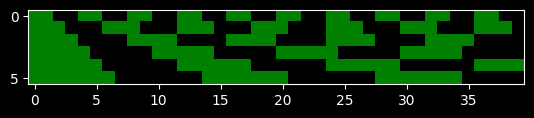

In [130]:
from matplotlib.colors import ListedColormap


tests = [
    {
        "name": "Example",
        "s": """
            addx 15
            addx -11
            addx 6
            addx -3
            addx 5
            addx -1
            addx -8
            addx 13
            addx 4
            noop
            addx -1
            addx 5
            addx -1
            addx 5
            addx -1
            addx 5
            addx -1
            addx 5
            addx -1
            addx -35
            addx 1
            addx 24
            addx -19
            addx 1
            addx 16
            addx -11
            noop
            noop
            addx 21
            addx -15
            noop
            noop
            addx -3
            addx 9
            addx 1
            addx -3
            addx 8
            addx 1
            addx 5
            noop
            noop
            noop
            noop
            noop
            addx -36
            noop
            addx 1
            addx 7
            noop
            noop
            noop
            addx 2
            addx 6
            noop
            noop
            noop
            noop
            noop
            addx 1
            noop
            noop
            addx 7
            addx 1
            noop
            addx -13
            addx 13
            addx 7
            noop
            addx 1
            addx -33
            noop
            noop
            noop
            addx 2
            noop
            noop
            noop
            addx 8
            noop
            addx -1
            addx 2
            addx 1
            noop
            addx 17
            addx -9
            addx 1
            addx 1
            addx -3
            addx 11
            noop
            noop
            addx 1
            noop
            addx 1
            noop
            noop
            addx -13
            addx -19
            addx 1
            addx 3
            addx 26
            addx -30
            addx 12
            addx -1
            addx 3
            addx 1
            noop
            noop
            noop
            addx -9
            addx 18
            addx 1
            addx 2
            noop
            noop
            addx 9
            noop
            noop
            noop
            addx -1
            addx 2
            addx -37
            addx 1
            addx 3
            noop
            addx 15
            addx -21
            addx 22
            addx -6
            addx 1
            noop
            addx 2
            addx 1
            noop
            addx -10
            noop
            noop
            addx 20
            addx 1
            addx 2
            addx 2
            addx -6
            addx -11
            noop
            noop
            noop
        """,
        "expected": """
            ##..##..##..##..##..##..##..##..##..##..
            ###...###...###...###...###...###...###.
            ####....####....####....####....####....
            #####.....#####.....#####.....#####.....
            ######......######......######......####
            #######.......#######.......#######.....
        """,
    },
]


class CRT:
    def __init__(self, s: str) -> None:
        self.rows = 6
        self.cols = 40
        self.display = [[""] * self.cols for _ in range(self.rows)]
        self.program = self.parse(s)

    def run(self, prt=False) -> CRT:
        x = 1
        pipeline = None
        ready = 0
        inst_counter = 0

        if prt:
            print(
                f"Sprite position: {''.join('#' if x-1<=i<=x+1 else '.' for i  in range(40))}\n"
            )

        for cycle in range(1, 241):

            if inst_counter < len(self.program) and ready <= 0:

                pipeline = self.program[inst_counter]

                if self.program[inst_counter][0] == "addx":
                    ready = 2
                else:
                    ready = 1

                if prt:
                    inst = self.program[inst_counter][0]
                    value = (
                        self.program[inst_counter][1]
                        if len(self.program[inst_counter]) > 1
                        else ""
                    )
                    print(f"Start cycle   {cycle}: begin executing {inst} {value}")

                inst_counter += 1

            row, pos = (cycle - 1) // 40, (cycle - 1) % 40

            self.display[row][pos] = "#" if x - 1 <= pos <= x + 1 else "."

            if prt:
                print(f"During cycle  {cycle}: CRT draws pixel in position {pos}")
                print(f"Current CRT row: {''.join(self.display[row])}")

            ready -= 1
            if ready <= 0:
                if pipeline[0] == "addx":
                    x += pipeline[1]
                    if prt:
                        print(
                            f"End of cycle  {cycle}: finish executing {pipeline[0]} {pipeline[1]} (Register X is now {x})"
                        )
                        print(
                            f"Sprite position: {''.join('#' if x-1<=i<=x+1 else '.' for i  in range(40))}"
                        )
                else:
                    if prt:
                        print(f"End of cycle  {cycle}: finish executing {pipeline[0]}")

            if prt:
                print()

        return self

    def show_display(self) -> None:
        cmp = ListedColormap(["black", "green"])
        grid = [[1 if v == "#" else 0 for v in r] for r in self.display]
        plt.imshow(grid, cmap=cmp)
        plt.show()

    @classmethod
    def parse(cls, s: str) -> list[list[str | int]]:
        program = []
        for l in s.strip().splitlines():
            inst, *value = l.strip().split()
            program.append((inst,) if inst == "noop" else (inst, int(value[0])))

        return program


def assert_function(actual: CRT, expected: str) -> bool:
    return "\n".join("".join(l) for l in actual.display) == "\n".join(
        "".join(l.strip()) for l in expected.strip().splitlines()
    )


@test(tests=tests, assert_funct=assert_function)
def test_part_II(s: str) -> int:
    return CRT(s).run()


_, s, *_ = tests[0].values()

CRT(s).run().show_display()

<link href="style.css" rel="stylesheet"></link>


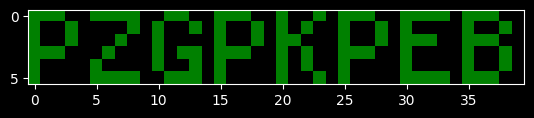

Part 2: PZGPKPEB


In [131]:
CRT(puzzle).run().show_display()
print(f"Part 2: PZGPKPEB")

<link href="style.css" rel="stylesheet"></link>

<main>

<p>Your puzzle answer was <code>PZGPKPEB</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>

</main>
